<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/colab_gan_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [17]:
#!pip install node2vec

In [2]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import csv
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
# load nodes details
with open("drive/MyDrive/data/aesthetics/colours.csv") as f:
    img_nodes = f.read().splitlines() 

# load edges (or links)
with open("drive/MyDrive/data/aesthetics/annotated_links.csv") as f:
        img_links = f.read().splitlines()  
len(img_nodes), len(img_links)

(45, 780)

In [4]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(img_links):
  if i.split(',')[2]=='1' or i.split(',')[2]=='0.5':
    node_list_1.append(i.split(',')[0])
    node_list_2.append(i.split(',')[1])
    node_list_1.append(i.split(',')[1])
    node_list_2.append(i.split(',')[0])

img_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2, 'Link': 1})

100%|██████████| 780/780 [00:00<00:00, 230602.46it/s]


In [5]:
img_df.head()

,node_1,node_2,Link
0,ae4j.png,ae4h.png,1
1,ae4h.png,ae4j.png,1
2,ae4j.png,ae5b.png,1
3,ae5b.png,ae4j.png,1
4,ae6f.png,ae6a.png,1


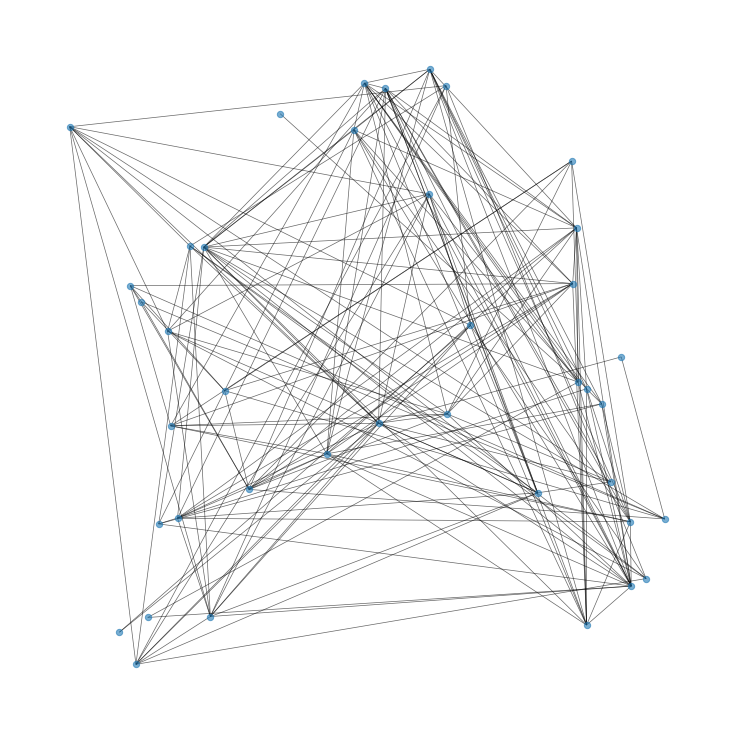

In [6]:
# create graph
G = nx.from_pandas_edgelist(img_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [50]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [33]:
# get unconnected node-pairs
all_unconnected_pairs = []

# captture nodes in 2 separate lists
unnode_list_1 = []
unnode_list_2 = []

for i in tqdm(img_links):
  if i.split(',')[2]=='0':
    unnode_list_1.append(i.split(',')[0])
    unnode_list_2.append(i.split(',')[1])
    unnode_list_1.append(i.split(',')[1])
    unnode_list_2.append(i.split(',')[0])

data = pd.DataFrame({'node_1': unnode_list_1, 'node_2': unnode_list_2, 'Link': 0})

100%|██████████| 780/780 [00:00<00:00, 264048.19it/s]


In [34]:
data.head()

,node_1,node_2,Link
0,ae6f.png,ae4h.png,0
1,ae4h.png,ae6f.png,0
2,ae6f.png,ae4j.png,0
3,ae4j.png,ae6f.png,0
4,ae1c.png,ae5g.png,0


In [35]:
print('links: ', img_df.shape[0], 'No links: ', data.shape[0])

links:  354 No links:  1206


In [36]:
nx.number_connected_components(G)

1

In [37]:
initial_node_count = len(G.nodes)

img_df_temp = img_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(img_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(img_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    img_df_temp = img_df_temp.drop(index = i)

100%|██████████| 354/354 [00:00<00:00, 621.14it/s]


In [38]:
# create dataframe of removable edges
img_df_ghost = img_df.loc[omissible_links_index]

data = data.append(img_df_ghost[['node_1', 'node_2', 'Link']], ignore_index=True)

In [39]:
img_df_ghost.head()

,node_1,node_2,Link
0,ae4j.png,ae4h.png,1
1,ae4h.png,ae4j.png,1
2,ae4j.png,ae5b.png,1
3,ae5b.png,ae4j.png,1
4,ae6f.png,ae6a.png,1


In [40]:
# drop removable edges
img_df_partial = img_df.drop(index=img_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(img_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [41]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/40 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:01<00:00, 39.13it/s]


In [42]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [43]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['Link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [44]:
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(1064, 100) (1064,) (457, 100) (457,)


In [45]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced')

In [46]:
predictions = lr.predict_proba(xtest)

In [47]:
roc_auc_score(ytest, predictions[:,1])

0.6157981803143093

In [49]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'false',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=10)

[1]	valid_0's auc: 0.734772
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.763323
[3]	valid_0's auc: 0.779201
[4]	valid_0's auc: 0.798269
[5]	valid_0's auc: 0.791622
[6]	valid_0's auc: 0.795699
[7]	valid_0's auc: 0.798298
[8]	valid_0's auc: 0.801105
[9]	valid_0's auc: 0.805787
[10]	valid_0's auc: 0.81044
[11]	valid_0's auc: 0.811326
[12]	valid_0's auc: 0.815757
[13]	valid_0's auc: 0.821532
[14]	valid_0's auc: 0.828814
[15]	valid_0's auc: 0.829995
[16]	valid_0's auc: 0.828888
[17]	valid_0's auc: 0.830305
[18]	valid_0's auc: 0.832905
[19]	valid_0's auc: 0.838459
[20]	valid_0's auc: 0.836863
[21]	valid_0's auc: 0.839049
[22]	valid_0's auc: 0.845341
[23]	valid_0's auc: 0.845903
[24]	valid_0's auc: 0.846759
[25]	valid_0's auc: 0.847424
[26]	valid_0's auc: 0.848783
[27]	valid_0's auc: 0.847808
[28]	valid_0's auc: 0.847158
[29]	valid_0's auc: 0.848281
[30]	valid_0's auc: 0.850142
[31]	valid_0's auc: 0.850171
[32]	valid_0's auc: 0.853687
[33]	valid_0's auc: 